# Day3: Polygons

The French 🇫🇷 national statistical office (Insee) gives us very
detailled information on income distribution in France. We will here use
city level information but you can even find income datasets aggregated
on 200m squares.

## Retrieve income data

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Filosofi dataset</h3>

We use a dataset called
[`Filosofi`](https://www.insee.fr/fr/metadonnees/source/serie/s1172)
that gives some information regarding income distribution at city level.
Here we only use median income but there are far more things in this
dataset.

</div>

We use [`pynsee`](https://github.com/InseeFrLab/pynsee) to retrieve
easily this dataset. We use data from 2016 but there are more recent
years available if needed.

In [1]:
import pynsee.download
df_city = pynsee.download.download_file("FILOSOFI_COM_2016")
df_city = df_city.dropna(subset = ['MED16'])
df_city['DEP'] = df_city['CODGEO'].str[:2]
df_city = df_city.loc[:, ['CODGEO','LIBGEO','MED16','DEP']]
df_paca = df_city.loc[df_city['DEP'].isin(['04','05','06','13','83','84'])]

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/78281770afe21f56f6df245bd6f30ea2
Set update=True to get the most up-to-date data

Extracting:   0%|          | 0.00/10.6M [00:00<?, ?B/s]Extracting: 100%|██████████| 10.6M/10.6M [00:00<00:00, 141MB/s]

## Retrieve borders

To retrieve official borders, we use
[`cartiflette`](https://github.com/InseeFrLab/pynsee) package that will
help us to only get cities that belong to French Provence.

In [2]:
import cartiflette.s3
paca = cartiflette.s3.download_vectorfile_url_all(
    values = "93", #regional code in French system for Provence
    level="COMMUNE",
    vectorfile_format="geojson",
    decoupage="region",
    year=2022)

To give more context, we will also plot departments which are a French
administrative level aggregating several cities together.

In [3]:
paca_dep = paca.dissolve('INSEE_DEP')

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Warning</h3>

We used a recent city borders shapefile (2022) but quite old income data
(2016). In this period, there has been some change in French cities
limits: some cities have been merged, others might have been split.

To be consistent, we should use the same year in both sources or
harmonize the limits. Since we did not do that, we end up with missing
data. They are shown in the map with special edges.

</div>

## Merging data with borders

Since we have a city unique identifier, we can just use `merge` from
`GeoPandas`.

In [4]:
import numpy as np
paca_filosofi_2016 = paca.merge(df_paca, left_on = "INSEE_COM", right_on = "CODGEO", how = "left")
paca_filosofi_2016['MED16'] = paca_filosofi_2016['MED16'].astype("double").div(1000)

## Producing the map

Text(0.12, 0.1, 'Twitter: @linogaliana\nSource: IGN - Insee ')

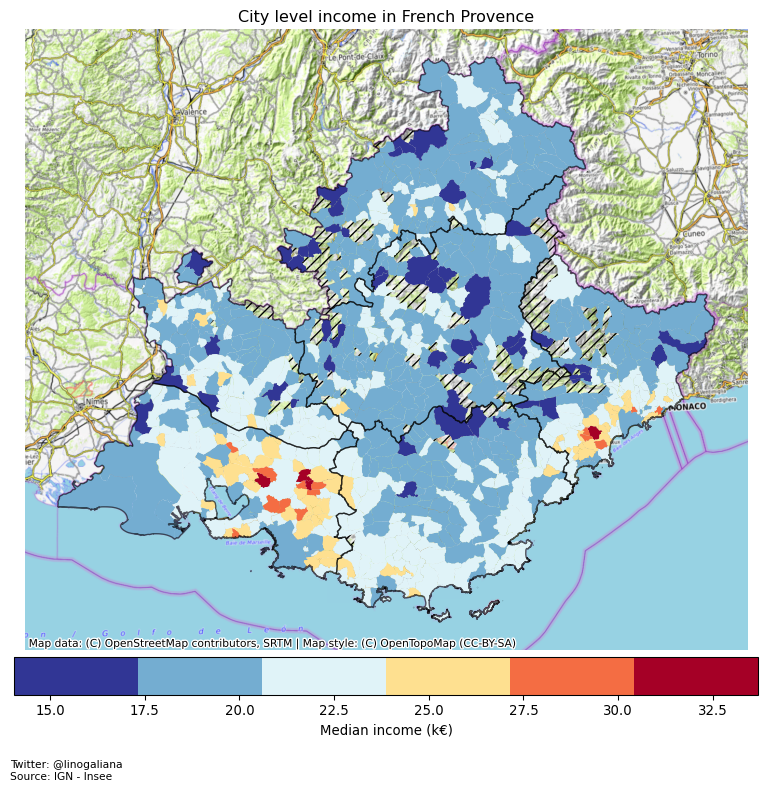

In [5]:
import matplotlib.pyplot as plt
import contextily as ctx

txt="Twitter: @linogaliana\nSource: IGN - Insee "


ax = paca_filosofi_2016.plot(figsize = (10,10), column = "MED16",
                             cmap = plt.cm.get_cmap('RdYlBu_r', 6),
                             legend=True,
                             legend_kwds={"orientation": "horizontal", "pad": 0.01,  "label": 'Median income (k€)'},
                             missing_kwds={
                                "color": "lightgrey",
                                "alpha": 0.2,
                                #"edgecolor": "black",
                                "hatch": "///",
                                "label": "Missing values",
    })
paca_dep.plot(ax = ax, zorder=1, edgecolor = "black", alpha = 0.6, facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.OpenTopoMap, crs = 2154)
ax.set_axis_off()
ax.set_title('City level income in French Provence')
plt.figtext(.12, .1, txt, wrap=True, horizontalalignment='left', fontsize=8)

In a future version of this document, I am going to try `observable.hq`
to produce a similar map.